In [6]:
import numpy as np
import pickle

from boxes import *
from learner import *

### Load ontology data

In [7]:
PATH = "../data/ontologies/anatomy/"

with open(f'{PATH}human.pickle', 'rb') as handle:
    human = pickle.load(handle)
    
with open(f'{PATH}mouse.pickle', 'rb') as handle:
    mouse = pickle.load(handle)

with open(f'{PATH}entities.pickle', 'rb') as handle:
    entities = pickle.load(handle)

In [8]:
ats = 0.8

unary_prob = torch.from_numpy(np.loadtxt(f'{PATH}unary/unary.tsv')).float().to("cpu")
num_boxes = unary_prob.shape[0]

PATH = "../data/ontologies/anatomy/subset/"
# Model was trained on the following data set: 
train = Probs.load_from_julia(PATH, f'tr_pos_{ats}.tsv', f'tr_neg_{ats}.tsv', ratio_neg = 0).to("cpu")

# Model was evaluated on the following data set:
dev = Probs.load_from_julia(PATH, f'dev_align_pos_{ats}.tsv', f'dev_align_neg_{ats}.tsv', ratio_neg = 1).to("cpu")

# Model was trained on the following (positive) alignments -- not the negatives:
tr_align = Probs.load_from_julia(PATH, f'tr_align_pos_{ats}.tsv', f'tr_align_neg_{ats}.tsv', ratio_neg = 1).to("cpu")

In [12]:
# mPATH = "../results/DeltaBoxes_nEpochs50_lr0.01_dims10_ratio1_split0.8_UnaryFalse0.1/model.pth"
mPATH = "../results/MinMaxSigmoidBoxes_nEpochs20_lr0.01_dims10_ratio1_split0.8_UnaryFalse0.01/model.pth"
model_data = torch.load(mPATH)

model = BoxModel(
    BoxParamType=MinMaxSigmoidBoxes,
    vol_func=soft_volume,
    num_models=1,
    num_boxes=num_boxes,
    dims=10,
    method="orig").to("cpu")

model.load_state_dict(model_data['state_dict'])

<All keys matched successfully>

In [13]:
# Get the coordinates of the boxes

beo = model(torch.tensor([[1, 1]]) )['box_embeddings_orig'].squeeze(0)

In [15]:
model_data.keys()
model_data['recorders']

RecorderCollection(learn=           mouse_cond_kl_loss  human_cond_kl_loss  0.05*align_cond_kl_loss  \
0.005650             1.513573            1.284088                 0.029980   
0.011299             1.520736            1.338882                 0.029382   
0.016949             1.377617            1.400375                 0.037320   
0.022599             1.482881            1.209440                 0.035692   
0.028249             1.447968            1.204116                 0.039426   
...                       ...                 ...                      ...   
19.977401            0.236297            0.421850                 0.037789   
19.983051            0.426704            0.363740                 0.037682   
19.988701            0.537071            0.351328                 0.035645   
19.994350            0.270324            0.465867                 0.038309   
20.000000            0.428260            0.364566                 0.036611   

               loss  
0.005650   2.827

### Find an alignment in the dev set that has a parent and child that is in the training alignment dataset

In [16]:
dev_pos_alignments = dev.tensors[0][:int(dev.tensors[0].shape[0]/2)]
dev_pos_nodes = torch.unique(dev_pos_alignments).cpu()

In [17]:
tr_pos_alignments = tr_align.tensors[0][:int(tr_align.tensors[0].shape[0]/2)]
tr_pos_nodes = torch.unique(tr_pos_alignments).cpu()

### Get the parents and children of the items in the dev_pos_nodes

In [18]:
# mouse dev parents & children
mdp = {}
mdc = {}

# human dev parents & children
hdp = {}
hdc = {}

for node in dev_pos_nodes:
    if node.item() in mouse['parents_of'] and node.item() in mouse['children_of']:
        mdp[node.item()] = mouse['parents_of'][node.item()] 
        mdc[node.item()] = mouse['children_of'][node.item()] 
        
    elif node.item() in human['parents_of'] and node.item() in human['children_of']:
        hdp[node.item()] = human['parents_of'][node.item()] 
        hdc[node.item()] = human['children_of'][node.item()]
        
    else:
        pass

### See if any of the dev_pos_nodes parents/children are in tr_pos_alignments

In [19]:
tr_pos_nodes

tensor([  0,   1,   2,   3,   4,   7,  12,  20,  27,  29,  35,  36,  38,  40,
         66,  73,  93, 110, 121, 139, 144, 145, 147, 148, 151, 153, 156, 157,
        160, 165, 169, 172, 173, 174, 177, 181, 184, 185, 186, 187, 188])

In [22]:
# a = [val for val in hdp[2741] if val in tr_pos_nodes] 
# b = [val for val in hdc[2741] if val in tr_pos_nodes] 

# if a and b:
#     print("yup")
# else:
#     print("nope")

In [23]:
# human dev nodes with parents & children in train (hdnwpcit): dictionary of nodes in dev 
# that have both parents and children as positive alignments in the training set
hdnwpcit_parents = {}
hdnwpcit_children = {}

mdnwpcit_parents = {}
mdnwpcit_children = {}

for key in hdp:
    # aligned parents in train (apit), aligned children in train (acit)
    hapit = [val for val in hdp[key] if val in tr_pos_nodes] 
    hacit = [val for val in hdc[key] if val in tr_pos_nodes] 
    
    if hapit and hacit:
        hdnwpcit_parents[key] = hapit
        hdnwpcit_children[key] = hacit
    else:
        pass
        # print(key, "does not have both parents and children as positive alignments in training set of alignments")
        
        
for key in mdp:
    # aligned parents in train (apit), aligned children in train (acit)
    mapit = [val for val in mdp[key] if val in tr_pos_nodes] 
    macit = [val for val in mdc[key] if val in tr_pos_nodes] 
    
    if mapit and macit:
        mdnwpcit_parents[key] = mapit
        mdnwpcit_children[key] = macit
    else:
        pass
        # print(key, "does not have both parents and children as positive alignments in training set of alignments")

In [24]:
# THIS LIST WILL BE A BIT SHORTER BECAUSE IT IS ESSENTIALLY ONLY KEEPING ALIGNMENTS IN THE DEV SET 
# THAT HAVE CHILDREN AND PARENTS AS ALIGNMENTS -- ACROSS BOTH ONTOLOGIES.

# EX) IF A NODE IN THE MOUSE SET HAS ALIGNMENTS AS PARENTS/CHILDREN BUT IT'S HUMAN ALIGNMENT DOESN'T, 
# IT WILL BE FILTERED OUT

alignments_in_dev_we_care_about = []
for hk in hdnwpcit_parents:
    for mk in mdnwpcit_parents:
        align = (hk, mk)
        if align in entities['alignments']:
            alignments_in_dev_we_care_about.append(align)

In [25]:
tpa = tr_pos_alignments.cpu().numpy()
train_aligns_compare = []
for row in tpa:
    train_aligns_compare.append((row[0], row[1]))

# (1812, 1812) in train_aligns_compare

In [26]:
# print(hdnwpcit_children[2741])
# print(mdnwpcit_children[29])

# MAKE A DICT OF THE CHILDREN AND THE PARENTS THAT HAVE ALIGNMENTS
alignments_wca_parents = {}
alignments_wca_children = {}

for align in alignments_in_dev_we_care_about:
    # GET PARENTS ON BOTH SIDES OF AN ALIGNMENT
    h_parents = hdnwpcit_parents[align[0]]
    m_parents = mdnwpcit_parents[align[1]]
    
    alignments_wca_parents[align] = []
    
    # COMPARE ALL PARENTS IN THE ONTOLOGIES TO SEE IF THAT ALIGNMENT IS IN THE TRAINING SET
    for hp in h_parents:
        for mp in m_parents:
            
            tr_align_p = (hp,mp)
            
            if tr_align_p in train_aligns_compare:
                alignments_wca_parents[align].append(tr_align_p)
    
    # GET CHILDREN ON BOTH SIDES OF AN ALIGNMENT
    h_children = hdnwpcit_children[align[0]]
    m_children = mdnwpcit_children[align[1]]
    
    alignments_wca_children[align] = []
    
    
    # COMPARE ALL CHILDREN IN THE ONTOLOGIES TO SEE IF THAT ALIGNMENT IS IN THE TRAINING SET
    for hc in h_children:
        for mc in m_children:
            
            tr_align_c = (hc,mc)
            
            if tr_align_c in train_aligns_compare:
                alignments_wca_children[align].append(tr_align_c)
                
            
# print(align, hdnwpcit_parents[align[0]], mdnwpcit_parents[align[1]]  )

In [27]:
final_dict_parents = {}
final_dict_children = {}

for key in alignments_wca_parents:
    if not alignments_wca_parents[key]:
        pass
    else:
        final_dict_parents[key] = alignments_wca_parents[key]
        final_dict_children[key] = alignments_wca_children[key]
        
print(len(alignments_wca_parents), "-->", len(final_dict_parents))

0 --> 0


In [28]:
for align in final_dict_parents:
    model_out1 = model(torch.tensor([[align[0], align[1]]]))['P(A|B)'].cpu().item()
    model_out2 = model(torch.tensor([[align[1], align[0]]]))['P(A|B)'].cpu().item()
    
    print("alignment:")
    print("\t", align, entities['idx2label'][align[0]], "<-->", entities['idx2label'][align[1]], end=", ")
    print("(", "%.2f" % model_out1,",", "%.2f" % model_out2, ")")
    
    
    print("parents:")
    for pa in final_dict_parents[align]: 
        model_out1 = model(torch.tensor([[pa[0], pa[1]]]))['P(A|B)'].cpu().item()
        model_out2 = model(torch.tensor([[pa[1], pa[0]]]))['P(A|B)'].cpu().item()
       
        print("\t", pa, entities['idx2label'][pa[0]], "<-->", entities['idx2label'][pa[1]], end=", ")
        print("(", "%.2f" % model_out1,",", "%.2f" % model_out2, ")")
        
    print("children:")
    for ca in final_dict_children[align]: 
        model_out1 = model(torch.tensor([[ca[0], ca[1]]]))['P(A|B)'].cpu().item()
        model_out2 = model(torch.tensor([[ca[1], ca[0]]]))['P(A|B)'].cpu().item()
        
        print("\t", ca, entities['idx2label'][ca[0]], "<-->", entities['idx2label'][ca[1]], end=", ")
        print("(", "%.2f" % model_out1,",", "%.2f" % model_out2, ")")

    print("\n")

In [29]:
alignment = (4299, 52)
special_parent_alignment = (3380, 32) 
special_child_alignment = (5357, 56)

parents_of_alignment_mouse = mouse['parents_of'][52]
parents_of_alignment_human = human['parents_of'][4299]

children_of_alignment_mouse = mouse['children_of'][52]
children_of_alignment_human = human['children_of'][4299]

print("================ Mouse ==================")
print("Parents of:", entities['idx2label'][52])

for p in parents_of_alignment_mouse:
    print(p, entities['idx2label'][p], end=', ')

print("\n\n", "Children of:", entities['idx2label'][52])
    
for c in children_of_alignment_mouse:
    print(c, entities['idx2label'][c], end=', ')

print("\n\n\n================ Human ==================")    
    
print("Parents of:", entities['idx2label'][4299])

for p in parents_of_alignment_human:
    print(p, entities['idx2label'][p], end=', ')
    
print("\n\n", "Children of:", entities['idx2label'][4299])

for c in children_of_alignment_human:
    print(c, entities['idx2label'][c], end=', ')
    

================ Mouse ==================
Parents of: foot
44 autopod, 32 hindlimb, 

 Children of: foot
56 foot digit, 57 metatarsus, 58 tarsus, 359 foot bone, 548 foot joint, 722 foot blood vessel, 725 foot connective tissue, 732 foot muscle, 734 foot nerve, 735 foot skin, 


================ Human ==================
Parents of: Foot
4298 Lower_Extremity_Part, 3380 Lower_Extremity, 

 Children of: Foot
4297 Dorsal_Region_of_Foot, 5012 Plantar_Region, 5357 Toe, 5779 Foot_Skin, 5830 Foot_Phalanx, 

In [30]:
print( [(p, entities['idx2label'][p]) for p in human['parents_of'][3380] ] )
print( [(p, entities['idx2label'][p]) for p in human['parents_of'][3030] ] )

[(3030, 'Limb')]
[(2784, 'Body_Region')]


In [31]:
print( [(p, entities['idx2label'][p]) for p in human['children_of'][3380] ] )
print( [(p, entities['idx2label'][p]) for p in human['parents_of'][4982] ] )

[(3377, 'Femoral_Vein'), (3382, 'Bone_of_the_Lower_Extremity'), (3471, 'Tibial_Artery'), (4299, 'Foot'), (4746, 'Leg'), (4982, 'Pelvic_Girdle')]
[(4298, 'Lower_Extremity_Part'), (3380, 'Lower_Extremity')]


In [32]:
a = torch.tensor([[11,3030]]) 
b = torch.tensor([[3030,11]])

print(model(a)['P(A|B)'].cpu().item())
print(model(b)['P(A|B)'].cpu().item())

(11,3030) in train_aligns_compare

0.6621345281600952
0.3805795907974243


False

In [34]:
def get_min_align_score(a, b):
    
    A_given_B = torch.stack((a,b), dim=1)
    B_given_A = torch.stack((b,a), dim=1)
    
    out1 = model(A_given_B)['P(A|B)']
    out2 = model(B_given_A)['P(A|B)']
    
    out_min, _ = torch.min(torch.stack( (out1,out2), dim=1) , dim=1)
    
    return out_min

num_nodes = len((entities['name2idx']))

all_alignments = torch.zeros((num_nodes, num_nodes))


for i in dev_pos_nodes:
#     aa = i.repeat(len((entities['name2idx']))).cuda()
#     bb = torch.range(0, len((entities['name2idx']))-1, dtype=torch.long).cuda()
    aa = i.repeat(len((entities['name2idx'])))
    bb = torch.range(0, len((entities['name2idx']))-1, dtype=torch.long)
    
    all_alignments[i.item()] = get_min_align_score(aa, bb)

# for i in dev_pos_nodes
# aa = dev_pos_nodes[0]
# all_alignments[aa] = []
# for j in range(len(entities['name2idx'])):
#     all_alignments[aa].append(get_min_align_score(aa, j))

# calc_all_alignments

/home/zonghaiyao/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].


In [35]:
mask = torch.eye(num_nodes).byte()
all_alignments.masked_fill_(mask, 0)

max_aligns = all_alignments.topk(k=5, dim=1)

topk_dev = all_alignments[dev_pos_nodes].topk(k=5, dim=1)

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [36]:
topk_dev.values.shape

torch.Size([10, 5])

In [37]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

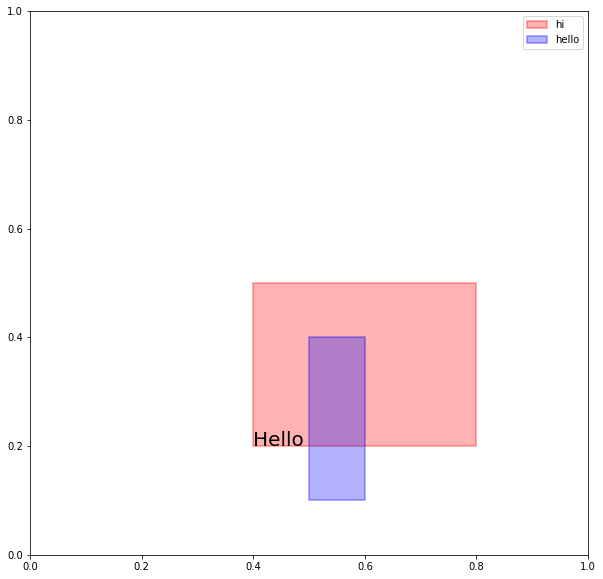

In [38]:
fig,ax = plt.subplots(1, figsize=(10,10), facecolor="white")

rect1 = patches.Rectangle((0.4,0.2),.4,.3,linewidth=2,edgecolor='r', fill=True, facecolor='r', alpha=0.3)
rect2 = patches.Rectangle((0.5,0.1),.1,.3,linewidth=2,edgecolor='b', fill=True, facecolor='b', alpha=0.3)
ax.text(0.4,0.2, "Hello", fontsize=20)

ax.add_patch(rect1)
ax.add_patch(rect2)
ax.legend(("hi","hello"))


plt.show()